# Compare implementations

In this notebook we want to compare the two implementations "polynomial.py/spline.py" and "tfspline".  
We want to identify possible differences and formulate hypotheses as to why one solution performs different from the other.
We do this by turning features in the tfspline solution on/off or adjusting tfspline parameters until both solutions give the same outputs.
This allows us to:
 - Identify features in both implementations that improve optimization performance, which we can then evaluate in more detail in a follow-up Jupyter notebook.
 - Continue to perform experiments with both solutions and expect comparable results

# Summary of findings

## Effects of shifting polynomial centers

1. Shifting by mean instead of left boundary point shows slightly better results.
   Need to verify if this is generally the case and how this behaves with a rising amount of polynomial segments.
2. Without polynomial shifting, SGD diverges for higher x-values, see section "2 Polynomials".
   This could be due to the fact that it is harder and harder to fit a polynomial with center $x=0$ to data points that lie at a greater $x$-distance to this center.

## Rescaling
Um wiederholbare Trianingseigenschaften und Lernraten zu erzielen, muss der Input-Raum einen einheitlichen Wertebereich besitzen.

Besonderes Augenmerk kommt dabei, bedingt durch die Definition von Polynomen als Summe von Potenzen von $x$, der $x$-Achse zu.
Dabei sollte jedes Polynom einen Range von [0 1] haben, damit bei steigender Polynomzahl das "Lernsignal" für höhere Potenzen nicht verschwindet.
Klar, denn bei $(x - \bar{x})^j$ wird ja, umso kleiner das x, das Ergebnis bei höheren Potenzen $j$ immer noch kleiner.

Damit muss der Datensatz bei $m$ Polynomen von 0 bis $m$ gehen (Also bei 8 Polynomen z.B. von 0 bis 8).
Damit die Polynome dann aber das "Ursprungsproblem" lösen, falls die Eingangsdomänen eigentlich andere waren, müssen diese wieder re-skaliert werden,
also statt

\begin{align}
  \overline{p}_i(x) = \sum_{j = 0}^d \alpha_{i, j} (x - \bar{x})^j.
\end{align}

\begin{align}
  \overline{p}_i(x) = \sum_{j = 0}^d \alpha_{i, j} (k\cdot(x - \bar{x}))^j.
\end{align}

Wir machen es uns hier einfach, und nehmen einfach als Ursprungsproblem eine x-Achse im Intervall von 0 bis $m$, sowie eine y-Achse von 0 bis 1 an.

## Compensate for rising number of polynomials $m$ in loss function

In an attempt to "increase the learning signal" for SGD with a rising number of polynomial pieces,
for $m$ polynomial pieces and $n$ data points, we calculate $\ell_2$-loss as:
  \
$
\ell_2 = \frac{m}{n}
\sum_i |f(x_i) - y_i|^2.
$

Tests show that this is benificial, as without this equilibration SGD fails to optimize higher order terms.

## $C^k$-optimization

Although we have confirmed in this Notebook that spline.py's ck-loss function numerically delivers the same result as the tfspline version if we have the same input,
with the spline.py version the TensorFlow GradientTape somehow only considers derivative 0 for Ck-optimization.
Discontinuities in derivatives 1 and 2 remain.
With $\lambda=0.5$ the tfspline implementation delivers an almost $C^2$-continuous result, while the spline.py result is $C^0$-continuous.

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat
import statistics

from tfspline import model
from tfspline import plot
from tfspline import sampledata

In [3]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import itertools

%load_ext autoreload
%autoreload 2
import polynomial
import spline

## Spline properties based on Stefan Huber's findings in "Polynomial approximation.ipynb"

### Learning rate

0.1

### Gradient regularization

SGD benefits from regularization while adaptive optimizers (Adam) do not.
However, the regularization does not have any negative effect with adaptive optimizers, so we will leave it on in both cases.

### Input data

Number of points: Increasing the number of points to be approximated regulates the convergence. However, the effect is mild.
Noise / shape of input: Does not affect convergence. Since shape and noise does not impair convergence,
we are free to choose an input point cloud resembling a typical rise sequence of a cam profile.

### Optimizers

We limit ourselves to SGD and Adam, as other optimizers fail for high learning rate (0.1) in our application.
SGD: nesterov = true, momentum = 0.95
Adam: amsgrad=True (use default settings beta1 = 0.9, beta2=0.999, epsilon=1e-07)

### Continuity

$C^2$-continuity is sufficient for a wide range of cam applications.
We will therefore go with $C^2$-continuous splines in our tests regarding continuity properties.

In [4]:
learning_rate_adam = 0.1 
learning_rate_sgd = 0.1
gradient_regularization=True
epochs=500
deg=5
continuity_class=2

## Input data
Since tests have shown that noise in the input data does not impair convergence,  
we will choose an input point cloud resembling a typical rise sequence of a cam profile.

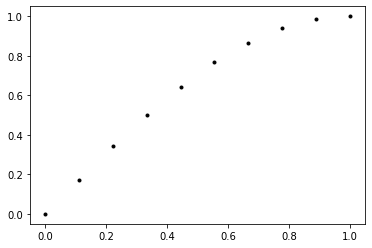

In [5]:
# Generate input data
xss = np.linspace(0, 1, 100, dtype="double")

data_x = np.linspace(xss[0], 0.5*np.pi, 10)
#data_x_norm /= data_x_norm[-1] # norm to 1
data_y = np.sin(data_x)

# Have to rescale input data, see section "Rescale" as to why
[data_x_norm, data_y_norm] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x_norm, data_y_norm, 'k.')

## Polynomial.ipynb definitions

In [6]:
def trans_probabilities(xs):
    """Takes a sequence of numbers and makes it sum up to one."""
    xs = np.array(xs)
    return xs / sum(xs)

def l2_sq_loss(coeffs, xs, ys):
    """The squared L2 loss of given polynomial on given data points (xs, ys). Loss is
    invariant on the length of xs.""" 
    return polynomial.l2_sq_error(coeffs, xs, ys) / len(xs)

def fit(xs, ys, degree, epochs=500, **kwargs):
    """Fits a polynomial. Returns coefficients and loss sequence."""
    
    # Load initial coeffs. This overrules the degree parameter in case
    # they would not agree
    if "coeffs" not in kwargs:
        # Note: Default dtype is tf.float32!
        coeffs = [tf.Variable(0.0, dtype=tf.float64) for _ in range(degree+1)]
    else:
        coeffs = [tf.Variable(c, dtype=tf.float64) for c in kwargs["coeffs"]]
        degree = len(coeffs) - 1
    
    if "optimizer" not in kwargs:
        optimizer = keras.optimizers.SGD(learning_rate=0.1)
    else:
        optimizer = kwargs["optimizer"]

    losses = [None for _ in range(epochs)]

    # Regularize depending on degree of coefficient
    if kwargs.get("regularize_grads_degree", True):        
        reg_grads = [1.0 / (1 + i) for i in range(len(coeffs))]
    else:
        reg_grads = np.ones(len(coeffs))
    # Make gradient regularization coefficients a probability distribution.
    # This makes the sum of gradients independent of degree.
    reg_grads = trans_probabilities(reg_grads)
    
    for epoch in range(epochs): 
        with tf.GradientTape() as tape:            
            loss = l2_sq_loss(coeffs, xs, ys)
            losses[epoch] = loss.numpy()
            if kwargs.get("print_progress", False) and epoch % 10 == 0:
                print("epoch=%d, loss=%4g\r" % (epoch, loss), end="")
        grads = tape.gradient(loss, coeffs)
        grads = [g * reg_grads[i] for i, g in enumerate(grads)]
        
        optimizer.apply_gradients(zip(grads, coeffs))
        
    if kwargs.get("print_progress", False):
        print()
        
    return [c.numpy() for c in coeffs], losses

# Approximation only, 1 polynomial

epoch=490, loss=0.00033211
epoch=490, loss=0.000139203


Text(0.5, 0, 'Epochs')

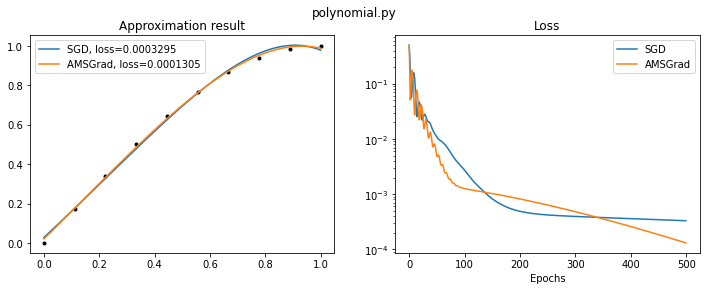

In [9]:
opt_sgd = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)
opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

coeffs_sgd, losses_sgd = fit(data_x_norm, data_y_norm, degree=deg, print_progress=True, epochs=epochs, optimizer=opt_sgd, regularize_grads_degree=gradient_regularization)
coeffs_ams, losses_ams = fit(data_x_norm, data_y_norm, degree=deg, print_progress=True, epochs=epochs, optimizer=opt_ams, regularize_grads_degree=gradient_regularization)

ps = polynomial.evaluate_vect(coeffs_sgd, xss)
ps2 = polynomial.evaluate_vect(coeffs_ams, xss)

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figwidth(12)
fig1.suptitle("polynomial.py")

ax1.plot(data_x_norm, data_y_norm, '.', c="black")
ax1.plot(xss, ps, label="SGD, loss=%.4g" % losses_sgd[-1])
ax1.plot(xss, ps2, label="AMSGrad, loss=%.4g" % losses_ams[-1])

ax1.legend(loc="best")
ax1.set_title("Approximation result")

ax2.semilogy(losses_sgd, label="SGD")
ax2.semilogy(losses_ams, label="AMSGrad")
ax2.legend(loc="best")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")

Text(0.5, 0, 'Epochs')

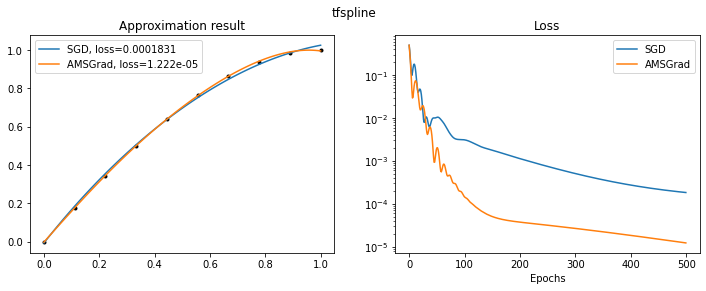

In [10]:
opt_sgd = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)
opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

spline_adam = model.Spline(polydegree=deg, polynum=1, ck=continuity_class)
spline_adam.continuity = False

spline_adam.fit(data_x_norm, data_y_norm, optimizer=opt_ams, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization)

spline_sgd = model.Spline(polydegree=deg, polynum=1, ck=continuity_class)
spline_sgd.continuity = False

spline_sgd.fit(data_x_norm, data_y_norm, optimizer=opt_sgd, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization)


fig1_tfspline, (ax3, ax4) = plt.subplots(1, 2)
fig1_tfspline.set_figwidth(12)
fig1_tfspline.suptitle("tfspline")

ax3.plot(data_x_norm, data_y_norm, '.', c="black")
ax3.plot(xss, spline_sgd.evaluate_spline_at_x(xss), label="SGD, loss=%.4g" % spline_sgd.total_loss_values[-1])
ax3.plot(xss, spline_adam.evaluate_spline_at_x(xss), label="AMSGrad, loss=%.4g" % spline_adam.total_loss_values[-1])

ax3.legend(loc="best")
ax3.set_title("Approximation result")

ax4.semilogy(spline_sgd.total_loss_values, label="SGD")
ax4.semilogy(spline_adam.total_loss_values, label="AMSGrad")
ax4.legend(loc="best")
ax4.set_title("Loss")
ax4.set_xlabel("Epochs")

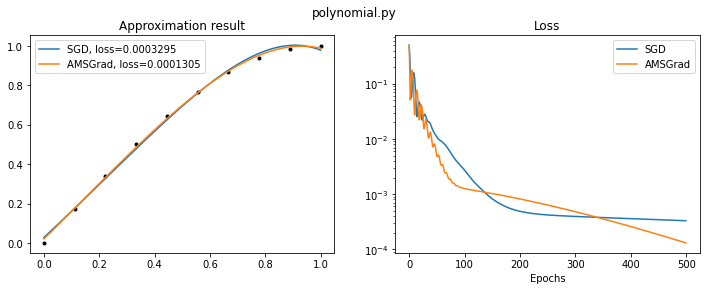

In [11]:
fig1

### Discussion

Why is the result different?
Both implementations use least square errors invariant to the number of data points and number of polynomials.  
However, the tfspline implementation centers each $p_i$ at the mean $\bar{x}$ of the respective interval by shifting it to
the right as

\begin{align}
  \overline{p}_i(x) = \sum_{j = 0}^d \alpha_{i, j} (x - \bar{x})^j.
\end{align}

Both the SGD and Adam optimizer seem to slightly benefit from this shifting when optimizing the approximation problem alone.
Let's now turn off this shifting behaviour and observe the results.

Text(0.5, 0, 'Epochs')

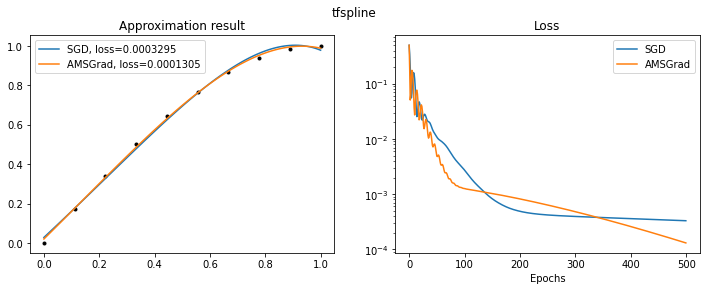

In [12]:
opt_sgd = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)
opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

spline_adam = model.Spline(polydegree=deg, polynum=1, ck=continuity_class)
spline_adam.continuity = False

spline_adam.fit(data_x_norm, data_y_norm, optimizer=opt_ams, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization, shift_polynomial_centers='off')

spline_sgd = model.Spline(polydegree=deg, polynum=1, ck=continuity_class)
spline_sgd.continuity = False

spline_sgd.fit(data_x_norm, data_y_norm, optimizer=opt_sgd, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization, shift_polynomial_centers='off')


fig1_tfspline, (ax3, ax4) = plt.subplots(1, 2)
fig1_tfspline.set_figwidth(12)
fig1_tfspline.suptitle("tfspline")

ax3.plot(data_x_norm, data_y_norm, '.', c="black")
ax3.plot(xss, spline_sgd.evaluate_spline_at_x(xss), label="SGD, loss=%.4g" % spline_sgd.total_loss_values[-1])
ax3.plot(xss, spline_adam.evaluate_spline_at_x(xss), label="AMSGrad, loss=%.4g" % spline_adam.total_loss_values[-1])

ax3.legend(loc="best")
ax3.set_title("Approximation result")

ax4.semilogy(spline_sgd.total_loss_values, label="SGD")
ax4.semilogy(spline_adam.total_loss_values, label="AMSGrad")
ax4.legend(loc="best")
ax4.set_title("Loss")
ax4.set_xlabel("Epochs")

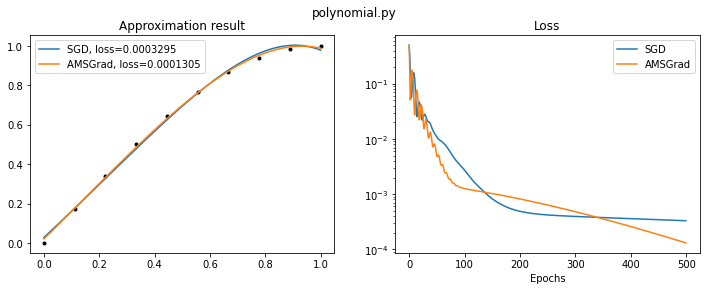

In [13]:
fig1

### Discussion

Without re-centering polynomials $p_i$ to their segment's mean x-value in the tfspline solution, both solutions return the same result.

# Approximation only, > 1 polynomial

## Spline.ipynb definitions

In [5]:
def trans_probabilities(xs):
    """Takes a sequence of numbers and makes it sum up to one."""
    xs = np.array(xs)
    return xs / sum(xs)

def combined_loss(sp, xs, ys, polynum, lambd):
    """Combined loss of l2 and C2-error"""
    return lambd * l2_sq_loss(sp, xs, ys, polynum) + (1 - lambd) *  tf.reduce_sum([l2_sq_k_disc_loss(sp, i) for i in range(3)])

def l2_sq_loss(sp, xs, ys, polynum):
    """The squared L2 loss of given spline on given data points (xs, ys). Loss is
    invariant on the length of xs."""
    return spline.l2_sq_error(sp, xs, ys) / len(xs) * polynum

def l2_sq_k_disc_loss(sp, k):
    """The k-th discontinuity loss."""
    # Get the vector of k-th discontinuities
    discs = next(itertools.islice(spline.discontinuities(sp), k, None))
    # Return the mean of squares of the discontinuities. The mean is there the be invariant for the
    # number of spline polynomials
    return tf.reduce_sum(tf.multiply(discs, discs)) / len(discs)

def fit_uniform(xs, ys, polynum, degree, epochs=500, loss_fn=combined_loss, initialize_l2_fit=False, lambd = 1, optarg={}, **kwargs):
    """Fit a spline for data points (xs, ys) with `polynum` polynomials of given degree."""

    if initialize_l2_fit:
        sp = spline.l2minmizer_uniform(xs, ys, polynum, degree)
    else:
        sp = spline.tf_zero_spline_uniform(xs, polynum, degree)
    tfvars = spline.tf_variables(sp)

    if "learning_rate" not in optarg:
        optarg["learning_rate"] = 0.1

    if "optimizer" not in kwargs or kwargs["optimizer"] == "adam":
        print("Use adam optimizer")
        optimizer = keras.optimizers.Adam(**optarg)
    elif kwargs["optimizer"] == "sgd":
        print("Use SGD optimizer")
        optimizer = keras.optimizers.SGD(**optarg, momentum=0.95, nesterov=True)
    else:
        print("Use supplied optimizer")
        optimizer = kwargs["optimizer"]

    splines = [None for _ in range(epochs)]
    losses = [None for _ in range(epochs)]

    # Regularize depending on degree of coefficient
    if kwargs.get("regularize_grads_degree", True):
        reg_grads = [1.0 / i for i in range(1, degree + 2)]
    else:
        reg_grads = np.ones(degree + 1)

    # Make gradient regularization coefficients a probability distribution.
    # This makes the sum of gradients independent of degree.
    reg_grads = trans_probabilities(reg_grads)
    reg_grads = np.tile(reg_grads, polynum)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            if lambd == 1:
                loss = loss_fn(sp, xs, ys, polynum)
            else:
                loss = loss_fn(sp, xs, ys, polynum, lambd)

        if kwargs.get("print_progress", False):
            print("epoch=%d, loss=%4g\r" % (epoch, loss.numpy()), end="")

        grads = tape.gradient(loss, tfvars)
        grads = [g * reg_grads[i] for i, g in enumerate(grads)]

        optimizer.apply_gradients(zip(grads, tfvars))

        # Recall spline
        splines[epoch] = spline.to_numpy(sp)
        losses[epoch] = loss.numpy()

    if kwargs.get("print_progress", False):
        print()

    return splines, losses

## Helper functions

In [6]:
def plot_spline_py_result(x, y, xs, p_num=1, ep=500, lr_sgd=learning_rate_sgd, initialize_l2_fit=False, lambd = 1):
    opt_sgd = keras.optimizers.SGD(learning_rate=lr_sgd, momentum=0.95, nesterov=True)
    opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

    if lambd != 1:
        splines_sgd, losses_sgd = fit_uniform(x, y, polynum=p_num, degree=deg, print_progress=True, epochs=ep, optimizer=opt_sgd, regularize_grads_degree=gradient_regularization,
                                              initialize_l2_fit=initialize_l2_fit, lambd=lambd, loss_fn=combined_loss)
        splines_ams, losses_ams = fit_uniform(x, y, polynum=p_num, degree=deg, print_progress=True, epochs=ep, optimizer=opt_ams, regularize_grads_degree=gradient_regularization,
                                              initialize_l2_fit=initialize_l2_fit, lambd=lambd, loss_fn=combined_loss)
    else:
        splines_sgd, losses_sgd = fit_uniform(x, y, polynum=p_num, degree=deg, print_progress=True, epochs=ep, optimizer=opt_sgd, regularize_grads_degree=gradient_regularization,
                                              initialize_l2_fit=initialize_l2_fit, lambd=lambd, loss_fn=l2_sq_loss)
        splines_ams, losses_ams = fit_uniform(x, y, polynum=p_num, degree=deg, print_progress=True, epochs=ep, optimizer=opt_ams, regularize_grads_degree=gradient_regularization,
                                              initialize_l2_fit=initialize_l2_fit, lambd=lambd, loss_fn=l2_sq_loss)

    # splines_sgd[-1] = spline at last epoch

    ck_pressure_sgd = 0
    for i in range(3):
        ds = l2_sq_k_disc_loss(splines_sgd[-1], i)
        ck_pressure_sgd += ds
    ck_pressure_ams = 0
    for i in range(3):
        ds = l2_sq_k_disc_loss(splines_ams[-1], i)
        ck_pressure_ams += ds

    fig2, fig2_axes = plt.subplots(1, 4, constrained_layout=True)
    fig2.set_figwidth(24)
    fig2.set_figheight(5)
    fig2.suptitle("spline.py\n" + "SGD, loss=%.4g" % losses_sgd[-1] + ", Ck-pressure=%.4g" % ck_pressure_sgd + "\nAMSGrad, loss=%.4g" % losses_ams[-1] + ", Ck-pressure=%.4g" % ck_pressure_ams)

    fig2_axes[0].plot(x, y, '.', c="black")

    sp_sgd = splines_sgd[-1]
    sp_ams = splines_ams[-1]

    for i in range(3):
        ps = spline.evaluate_vect_sorted(sp_sgd, xs)
        ps2 = spline.evaluate_vect_sorted(sp_ams, xs)
        fig2_axes[i].plot(xs, ps, label="SGD")
        fig2_axes[i].plot(xs, ps2, label="AMSGrad")
        fig2_axes[i].set_title(f'derivative {i}')
        fig2_axes[i].legend(loc="best")
        sp_sgd = spline.derive(sp_sgd)
        sp_ams = spline.derive(sp_ams)

    fig2_axes[-1].semilogy(losses_sgd, label="SGD")
    fig2_axes[-1].semilogy(losses_ams, label="AMSGrad")
    fig2_axes[-1].legend(loc="best")
    fig2_axes[-1].set_title("Loss")
    fig2_axes[-1].set_xlabel("Epochs")

    return fig2

def plot_tfspline_result(x, y, xs, p_num=1, ep=500, shift_polynomial_centers='off', overlap_segments=0, split_uniform=False, initialize_l2_fit=False, lambd = 1, ck=continuity_class):
    ck_factor = 1 - lambd
    approx_factor = lambd
    opt_sgd = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)
    opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

    spline_adam = model.Spline(polydegree=deg, polynum=p_num, ck=ck)
    spline_adam.continuity = False
    spline_adam.verbose = True

    spline_adam.fit(x, y, optimizer=opt_ams, n_epochs=ep, factor_approximation_quality=approx_factor,
    factor_ck_pressure=ck_factor, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=overlap_segments,
                    shift_polynomial_centers=shift_polynomial_centers, uniform_split=split_uniform, initialize_l2fit=initialize_l2_fit)

    spline_sgd = model.Spline(polydegree=deg, polynum=p_num, ck=ck)
    spline_sgd.continuity = False
    spline_sgd.verbose = True

    spline_sgd.fit(x, y, optimizer=opt_sgd, n_epochs=ep, factor_approximation_quality=approx_factor,
    factor_ck_pressure=ck_factor, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=overlap_segments,
                   shift_polynomial_centers=shift_polynomial_centers, uniform_split=split_uniform, initialize_l2fit=initialize_l2_fit)

    ck_pressure_sgd, _ = spline_sgd.ck_pressure()
    ck_pressure_ams, _ = spline_adam.ck_pressure()

    fig2_tfspline, fig2_tfspline_axes = plt.subplots(1, 4, constrained_layout=True)
    fig2_tfspline.set_figwidth(24)
    fig2_tfspline.set_figheight(5)
    fig2_tfspline.suptitle("tfspline\n" + "SGD, loss=%.4g" % spline_sgd.total_loss_values[-1] + ", Ck-pressure=%.4g" % ck_pressure_sgd + "\nAMSGrad, loss=%.4g" % spline_adam.total_loss_values[-1] + ", Ck-pressure=%.4g" % ck_pressure_ams)

    fig2_tfspline_axes[0].plot(x, y, '.', c="black")

    for i in range(3):
        fig2_tfspline_axes[i].plot(xs, spline_sgd.evaluate_spline_at_x(xs, deriv=i), label="SGD")
        fig2_tfspline_axes[i].plot(xs, spline_adam.evaluate_spline_at_x(xs, deriv=i), label="AMSGrad")
        fig2_tfspline_axes[i].set_title(f'derivative {i}')
        fig2_tfspline_axes[i].legend(loc="best")

    fig2_tfspline_axes[-1].semilogy(spline_sgd.total_loss_values, label="SGD")
    fig2_tfspline_axes[-1].semilogy(spline_adam.total_loss_values, label="AMSGrad")
    fig2_tfspline_axes[-1].legend(loc="best")
    fig2_tfspline_axes[-1].set_title("Loss")
    fig2_tfspline_axes[-1].set_xlabel("Epochs")

    return fig2_tfspline

## Verify that results are the same with 1 polynomial also for spline.py

TensorFlow: Number of recognized GPUs:  0
Fitting took 3.427133321762085 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2170000076293945 seconds


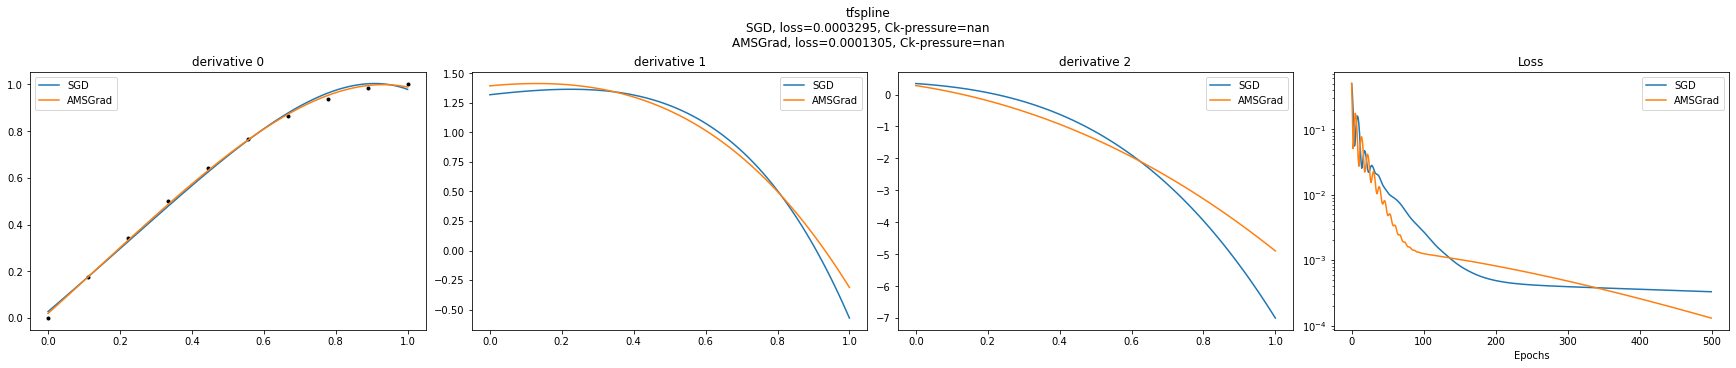

In [16]:
fig = plot_tfspline_result(data_x_norm, data_y_norm, xss, p_num=1, ep=epochs, shift_polynomial_centers='off')

Use supplied optimizer
epoch=499, loss=0.000329499
Use supplied optimizer
epoch=499, loss=0.000130517


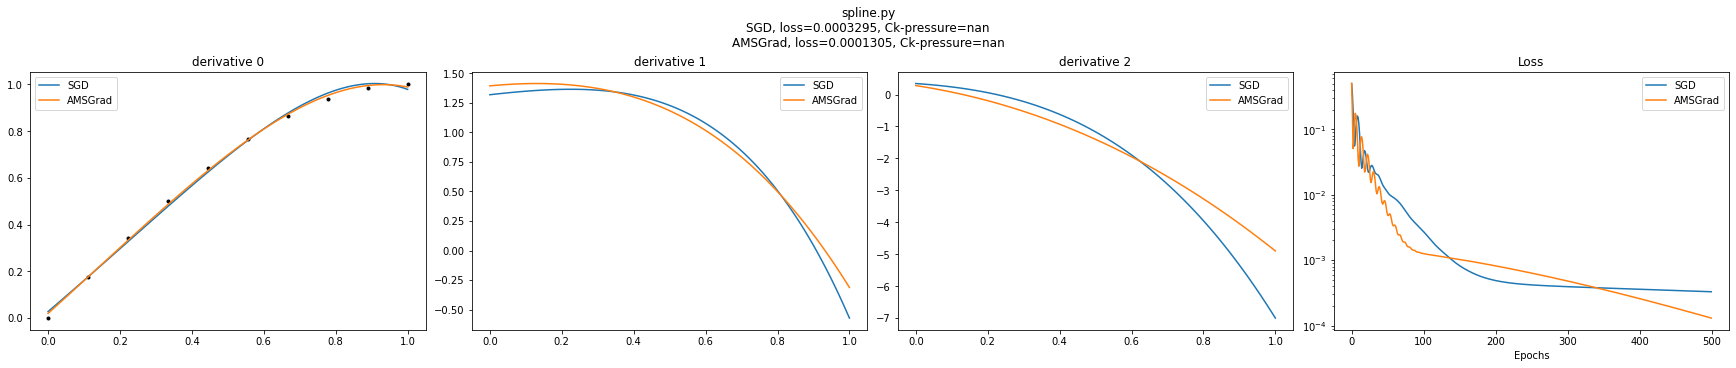

In [17]:
fig = plot_spline_py_result(data_x_norm, data_y_norm, xss, p_num=1, ep=epochs)

### Discussion

Results are the same for 1 polynomial.

## 2 Polynomials

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.629037380218506 seconds
TensorFlow: Number of recognized GPUs:  0
poch=280, loss=0.000749526epoch=310, loss=0.000707992epoch=330, loss=0.000682035epoch=360, loss=0.00064552epoch=380, loss=0.000622687epoch=410, loss=0.000590538epoch=430, loss=0.000570417epoch=450, loss=0.000551279epoch=470, loss=0.000533071Fitting took 5.444441318511963 seconds


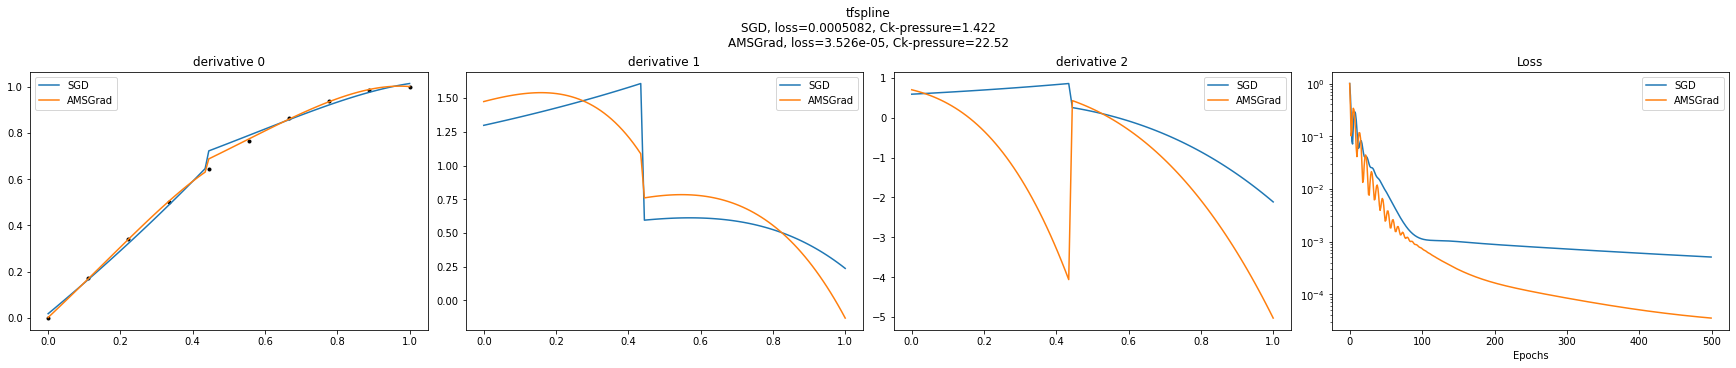

In [18]:
fig = plot_tfspline_result(data_x_norm, data_y_norm, np.linspace(0, data_x_norm[-1], 100, dtype="double"), p_num=2, ep=epochs, overlap_segments=0, shift_polynomial_centers='off')

Use supplied optimizer
epoch=499, loss=0.000825773
Use supplied optimizer
epoch=499, loss=3.74057e-05


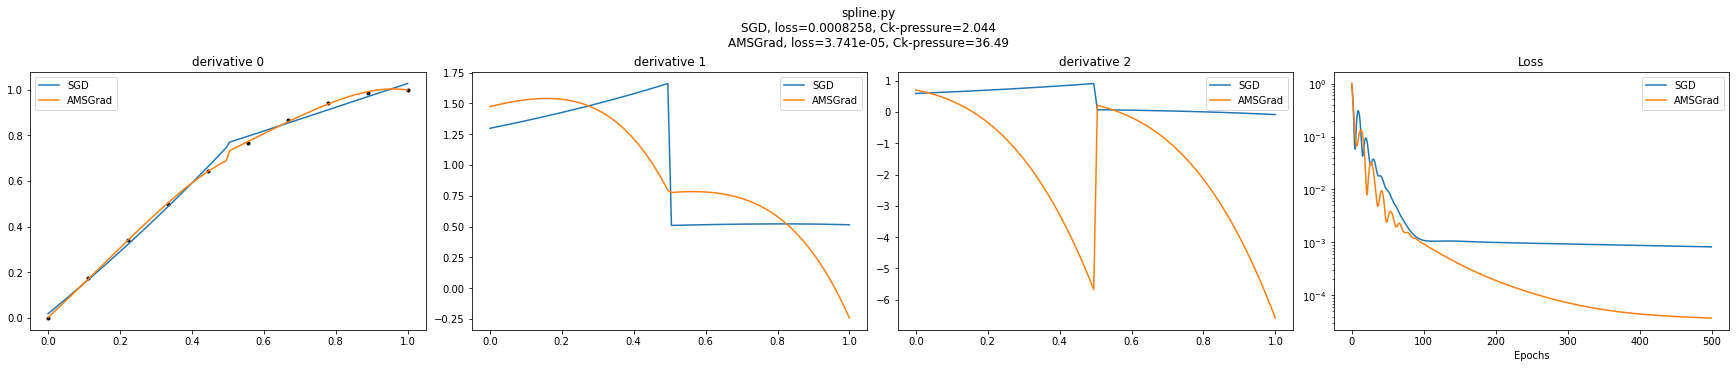

In [19]:
fig_spline_py_2_polynomials = plot_spline_py_result(data_x_norm, data_y_norm, np.linspace(0, data_x_norm[-1], 100, dtype="double"), p_num=2, ep=epochs)

### Discussion

For both SGD and AMSGrad, the results are similar, but not the same.
- spline.py divides the input space into uniform segments (boundary point between data points 5 and 6)
- tfspline divides the input space into non-uniform segments(boundary point at data point 5)

Let's assimilate the tfspline behaviour and verify the result.


TensorFlow: Number of recognized GPUs:  0
Fitting took 5.6650402545928955 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.3666672706604 seconds, loss=0.000749526epoch=310, loss=0.000707992epoch=340, loss=0.00066955epoch=360, loss=0.00064552epoch=390, loss=0.000611699epoch=420, loss=0.000580351epoch=440, loss=0.000560728epoch=470, loss=0.000533071epoch=490, loss=0.000515742


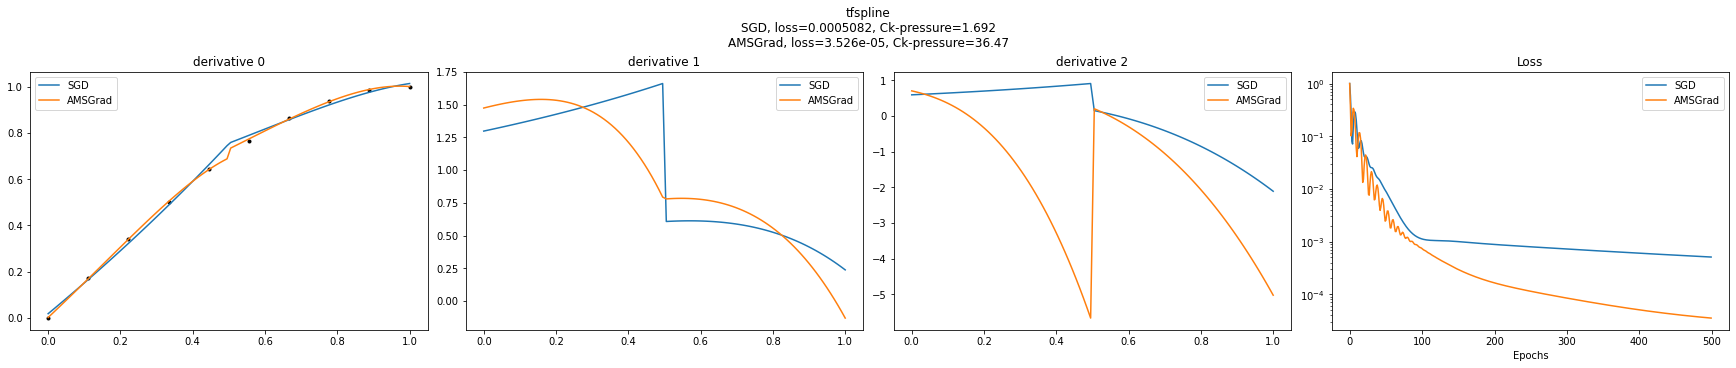

In [20]:
fig = plot_tfspline_result(data_x_norm, data_y_norm, np.linspace(0, data_x_norm[-1], 100, dtype="double"), p_num=2, ep=epochs, overlap_segments=0, split_uniform=True)

### Discussion
Also with uniformly splitting the input data space, the approximation- and ck-loss levels stay the same.
They remain slightly lower than with the spline.py solution.

Further investigation shows, that the spline.py solution also re-centers polynomials $p_i$ to their segment's x-value range.
However, it does not shift each polynomial to the right by the mean $\bar{x}$ of the respective interval,
but by the segment's left boundary point $\xi_{i,left}$.

Let's verify results with adjusted tfspline behaviour.

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.595084190368652 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.562164545059204 seconds


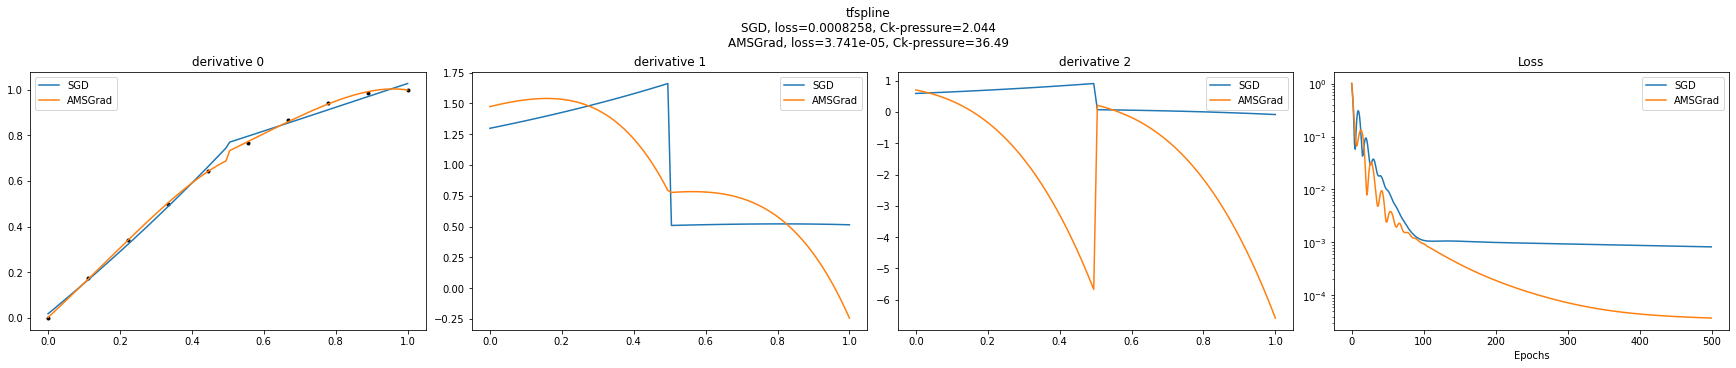

In [21]:
fig = plot_tfspline_result(data_x_norm, data_y_norm, np.linspace(0, data_x_norm[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

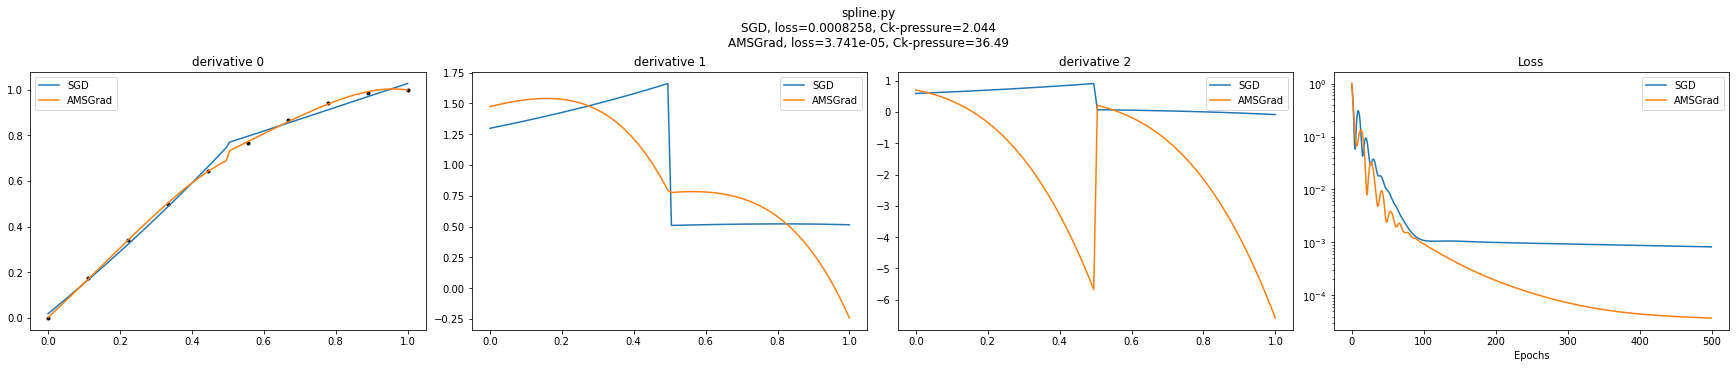

In [22]:
fig_spline_py_2_polynomials

## Discussion

Now both solutions deliver the same results.

Additional test:
As outlined in section "Rescaling", we need to rescale our input data for 2 polynomials.

In [23]:
x = 2 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.653085947036743 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.413646459579468 seconds


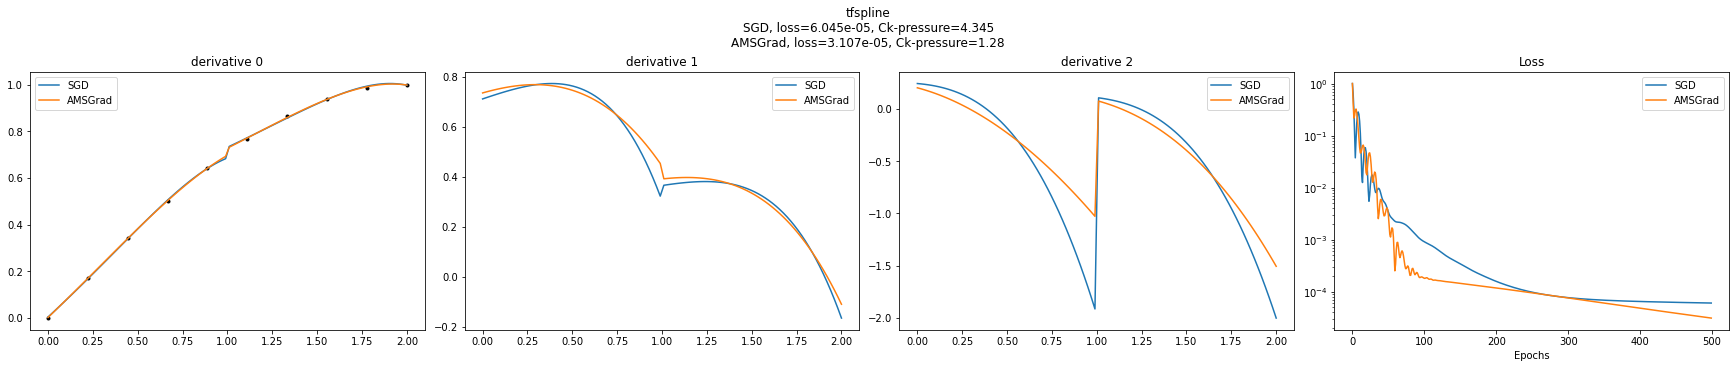

In [24]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
ch=43, loss=0.00553214epoch=55, loss=0.00256468epoch=67, loss=0.00213037epoch=79, loss=0.00168547epoch=89, loss=0.00119668epoch=101, loss=0.000892434epoch=112, loss=0.000740762epoch=124, loss=0.000564513epoch=135, loss=0.000445066epoch=147, loss=0.000361319epoch=157, loss=0.000301964epoch=167, loss=0.000253153epoch=177, loss=0.000216543epoch=189, loss=0.00018236epoch=199, loss=0.000159503epoch=209, loss=0.000141358epoch=219, loss=0.000126936epoch=231, loss=0.000113228epoch=242, loss=0.0001034epoch=252, loss=9.62757e-05epoch=261, loss=9.10252e-05epoch=272, loss=8.57932e-05epoch=284, loss=8.12682e-05epoch=296, loss=7.76981e-05epoch=308, loss=7.48573e-05epoch=320, loss=7.2577e-05epoch=332, loss=7.07279e-05epoch=344, loss=6.92101e-05epoch=356, loss=6.79474e-05epoch=367, loss=6.69641e-05epoch=379, loss=6.6039e-05epoch=390, loss=6.5297e-05epoch=402, loss=6.45779e-05epoch=413, loss=6.39838e-05epoch=423, loss=6.34866e-05epoch=434, loss=6.29774e-05epoch=444, loss=6.25424e

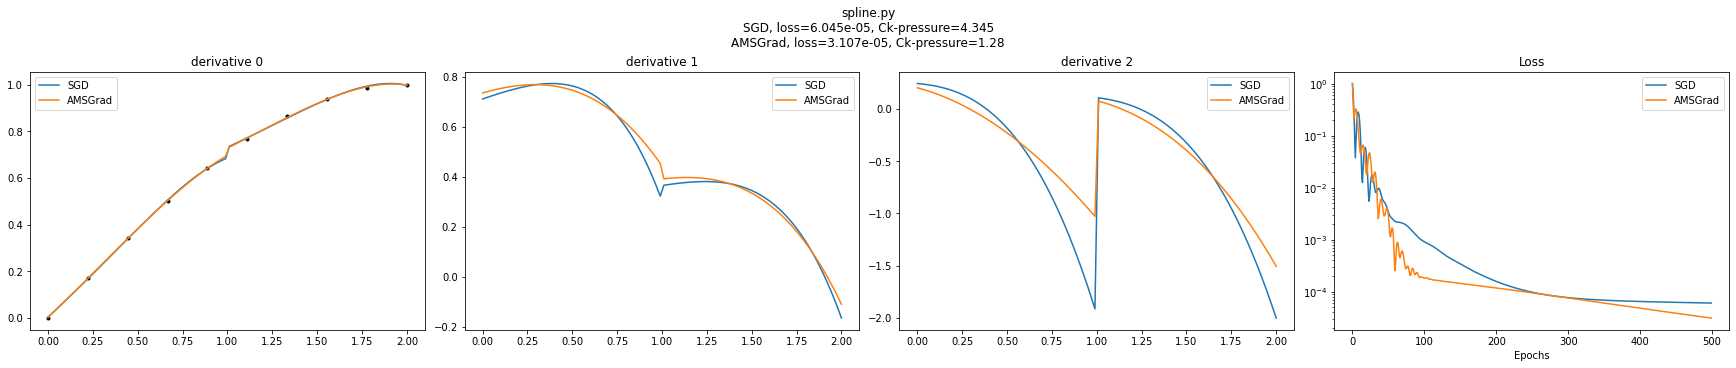

In [25]:
fig_spline_py_2_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs)

## Discussion

Both implementations deliver the same results.

Let's take a look at how the optimization routine performs with mean shifting, and shifting turned off.

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.582181692123413 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.309701681137085 seconds


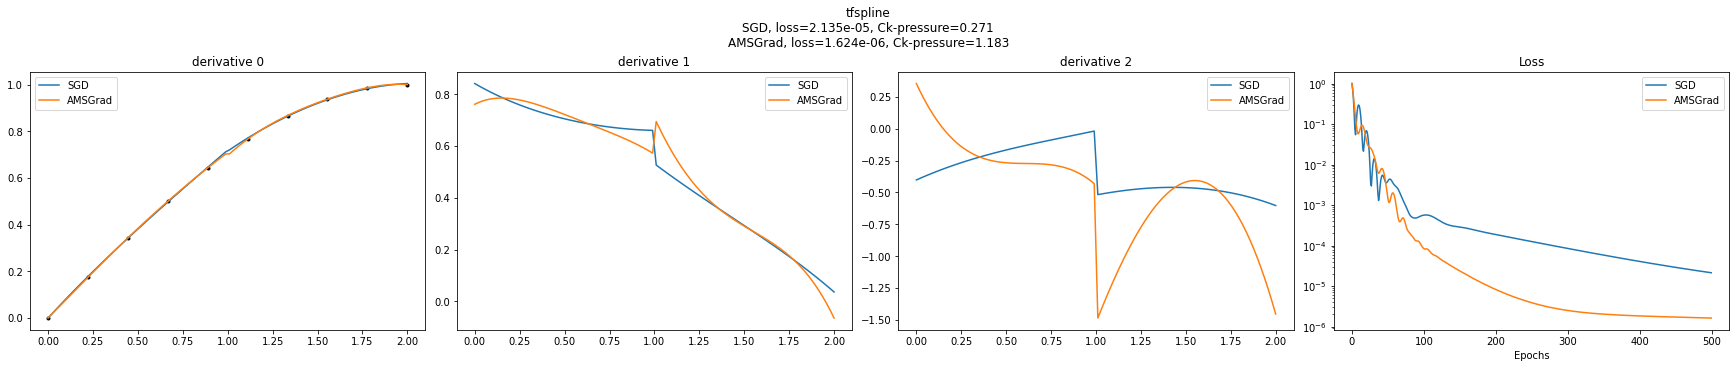

In [26]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='mean', overlap_segments=0, split_uniform=True)

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.661742925643921 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.400235414505005 seconds loss= infepoch=200, loss= infepoch=230, loss= infepoch=250, loss= infepoch=280, loss= infepoch=300, loss= infepoch=320, loss= nanepoch=350, loss= nanepoch=370, loss= nanepoch=390, loss= nanepoch=410, loss= nanepoch=430, loss= nanepoch=450, loss= nanepoch=470, loss= nanepoch=490, loss= nan


c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


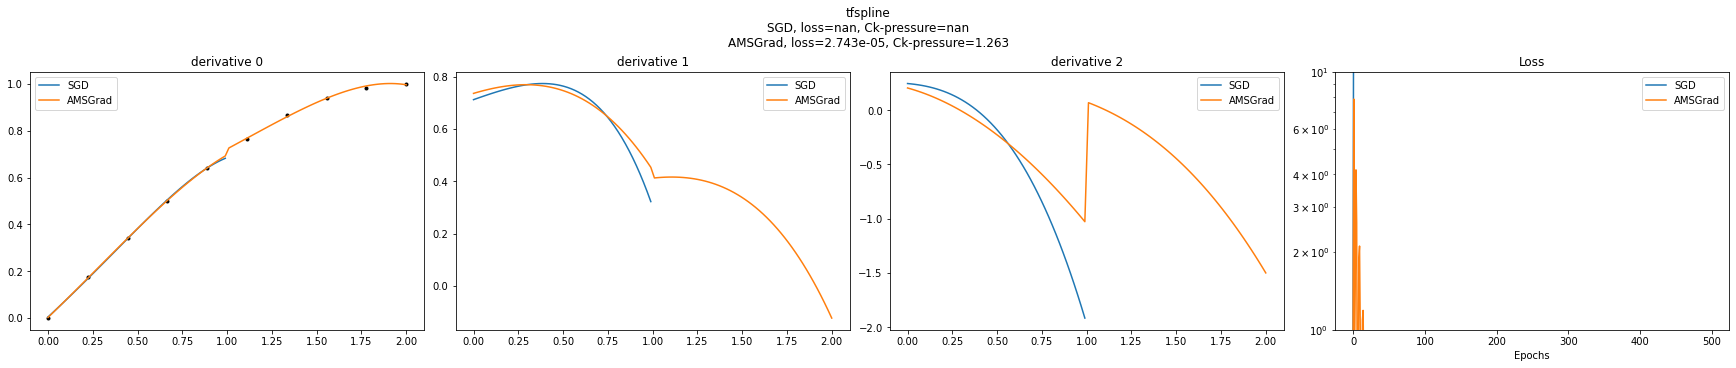

In [27]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='off', overlap_segments=0, split_uniform=True)

### Discussion

Interestingly, with higher x-values, without shifting polynomial centers, the optimization for SGD diverges!
This shows that shifting of polynomial centers is required.

Here, two effects come into play:
 - As described in "Summary of Findings - Rescaling", each polynomial needs to be assigned an interval of [0, 1]
   to establish same optimization conditions for all polynomial segments
 - In this 2 polynomial example, if polynomial 2 is not shifted to its corresponding segment,
   it's center lies at (0,0), which is the beginning of the first segment.
 - The optimization task is now "harder" to accomplish for polynomial 2, as its center is farther away from the points it needs to apporximate,
   but also because the interval it covers is actually bigger, namely [0, 2]

Again, shifting to the mean of the segment performs the best.

# Input data with more points

In order to allow for more segments, let's increase the number of points of our input function.

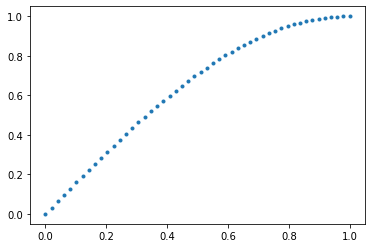

In [7]:
xss = np.linspace(0, 0.5*np.pi, 2000, dtype="double")

data_x = np.linspace(0, 0.5*np.pi, 50)
#data_x_norm /= data_x_norm[-1] # norm to 1
#data_x = data_x_norm[:]

data_y = np.sin(data_x)

# Have to rescale input data, see section "Rescale" as to why
[data_x_norm, data_y_norm] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x_norm, data_y_norm, '.')

## 2 Polynomials

In [29]:
x = 2 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.866089820861816 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.364150762557983 seconds


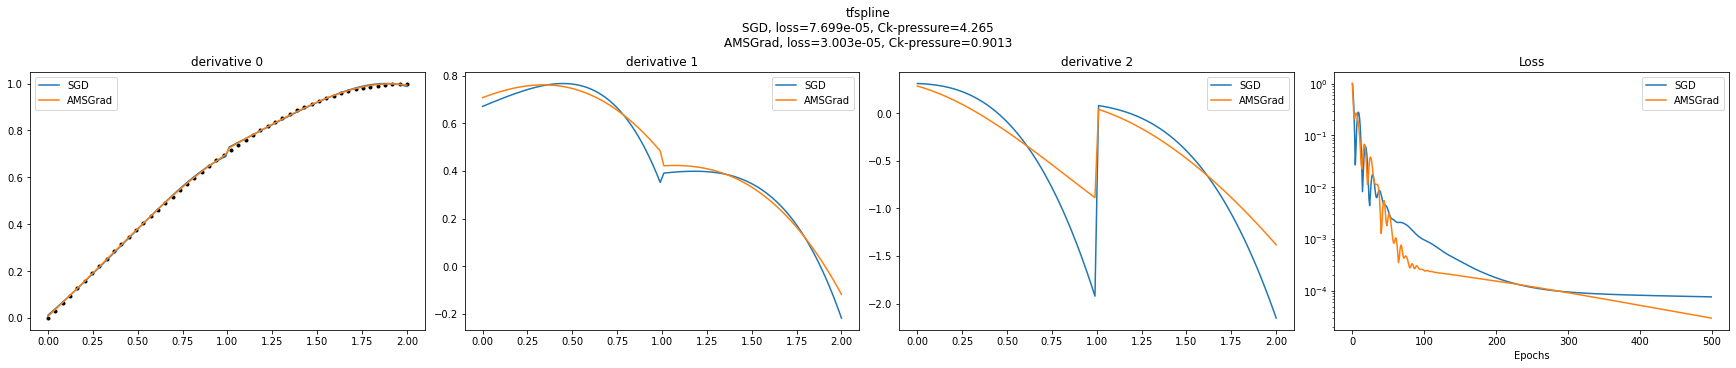

In [30]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
poch=330, loss=8.96274e-05epoch=334, loss=8.90395e-05epoch=337, loss=8.8621e-05epoch=340, loss=8.82202e-05epoch=344, loss=8.77116e-05epoch=347, loss=8.73479e-05epoch=350, loss=8.69985e-05epoch=354, loss=8.6553e-05epoch=357, loss=8.62331e-05epoch=361, loss=8.5824e-05epoch=364, loss=8.55294e-05epoch=367, loss=8.52444e-05epoch=370, loss=8.49685e-05epoch=374, loss=8.46136e-05epoch=377, loss=8.43565e-05epoch=380, loss=8.41066e-05epoch=384, loss=8.37839e-05epoch=387, loss=8.35491e-05epoch=391, loss=8.3245e-05epoch=394, loss=8.30232e-05epoch=397, loss=8.28063e-05epoch=401, loss=8.25244e-05epoch=404, loss=8.23179e-05epoch=408, loss=8.20488e-05epoch=411, loss=8.18513e-05epoch=414, loss=8.16572e-05epoch=417, loss=8.14663e-05epoch=421, loss=8.12165e-05epoch=424, loss=8.10325e-05epoch=428, loss=8.07911e-05epoch=431, loss=8.06129e-05epoch=435, loss=8.03788e-05epoch=439, loss=8.01484e-05epoch=442, loss=7.99779e-05epoch=445, loss=7.98092e-05epoch=448, loss=7.96422e-05epoch=451,

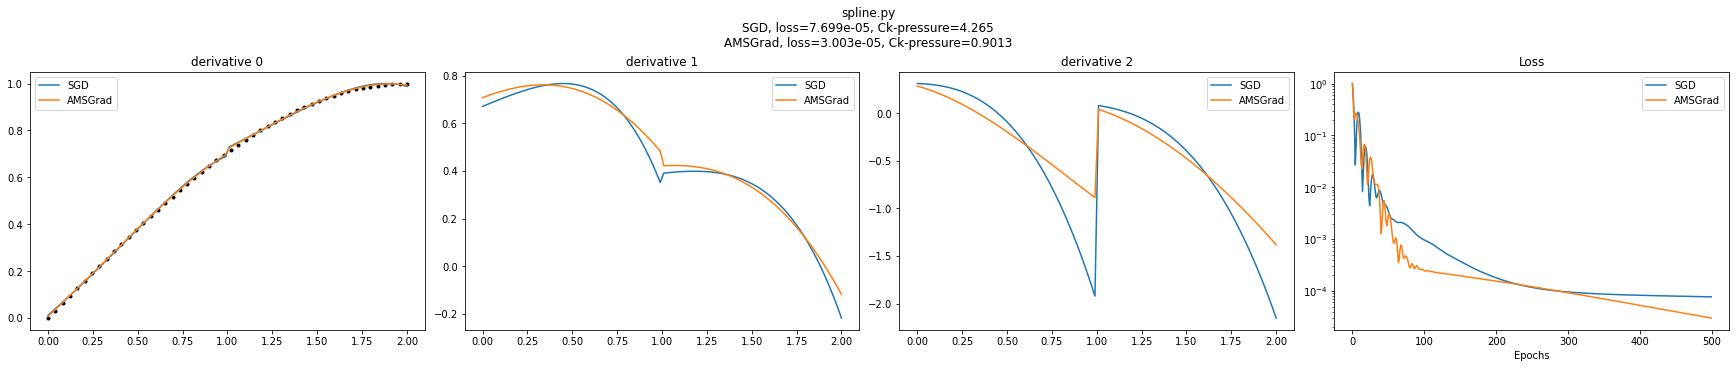

In [31]:
fig_spline_py_2_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs)

## 3 Polynomials

In [32]:
x = 3 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 7.991984605789185 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 7.925271987915039 seconds


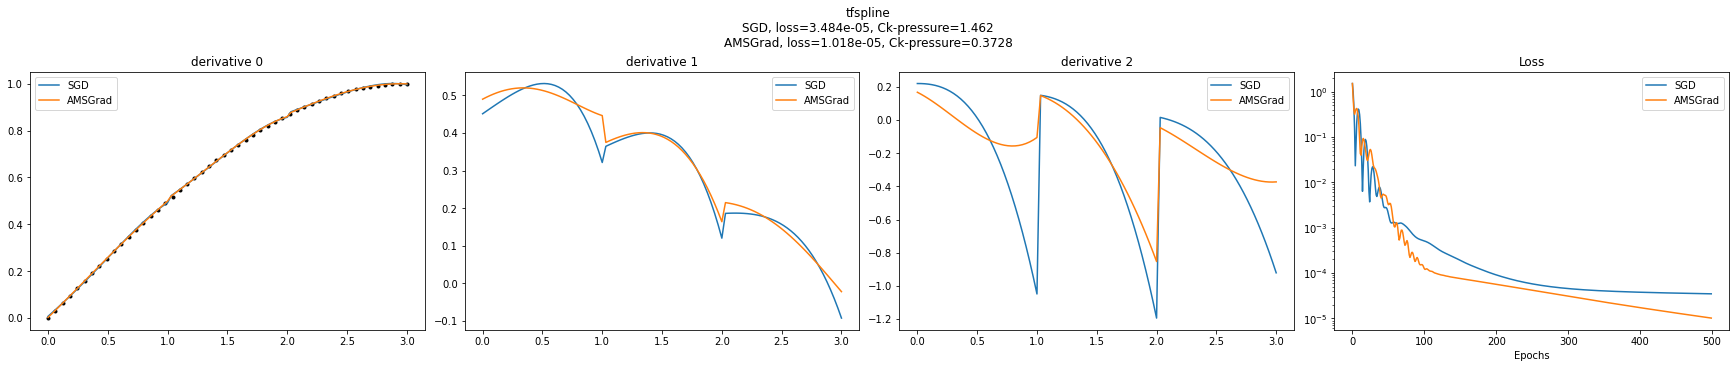

In [33]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=3, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
poch=158, loss=0.000164772epoch=162, loss=0.000154319epoch=165, loss=0.000147259epoch=169, loss=0.000138647epoch=172, loss=0.000132655epoch=175, loss=0.000126987epoch=178, loss=0.00012161epoch=181, loss=0.000116517epoch=184, loss=0.000111713epoch=187, loss=0.000107205epoch=190, loss=0.000102995epoch=193, loss=9.90751e-05epoch=196, loss=9.54275e-05epoch=199, loss=9.20299e-05epoch=202, loss=8.88573e-05epoch=205, loss=8.58858e-05epoch=208, loss=8.30954e-05epoch=211, loss=8.04704e-05epoch=214, loss=7.79992e-05epoch=217, loss=7.56735e-05epoch=220, loss=7.34867e-05epoch=223, loss=7.14323e-05epoch=227, loss=6.88883e-05epoch=230, loss=6.71172e-05epoch=233, loss=6.5455e-05epoch=236, loss=6.38939e-05epoch=239, loss=6.24264e-05epoch=242, loss=6.10456e-05epoch=245, loss=5.97453e-05epoch=248, loss=5.85202e-05epoch=251, loss=5.73656e-05epoch=254, loss=5.62771e-05epoch=258, loss=5.49221e-05epoch=261, loss=5.39733e-05epoch=264, loss=5.30785e-05epoch=267, loss=5.22343e-05epoch=27

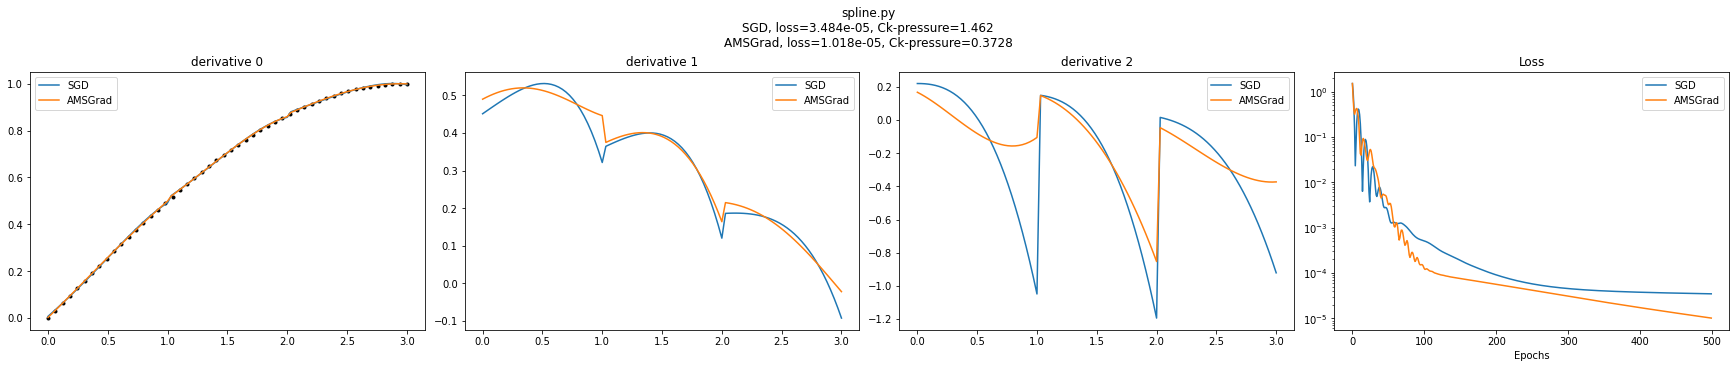

In [34]:
fig_spline_py_3_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=3, ep=epochs)

## 4 Polynomials

In [35]:
x = 4 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 10.30753231048584 seconds
TensorFlow: Number of recognized GPUs:  0
h=40, loss=0.00617473epoch=70, loss=0.000909185epoch=100, loss=0.000342014epoch=120, loss=0.000200624epoch=140, loss=0.000141318epoch=160, loss=9.80427e-05epoch=180, loss=7.24783e-05epoch=200, loss=5.59217e-05epoch=220, loss=4.5024e-05epoch=240, loss=3.78208e-05epoch=260, loss=3.29297e-05epoch=290, loss=2.82867e-05epoch=320, loss=2.55195e-05epoch=340, loss=2.42814e-05epoch=360, loss=2.33496e-05epoch=380, loss=2.26276e-05epoch=410, loss=2.18019e-05epoch=440, loss=2.11685e-05epoch=460, loss=2.08127e-05epoch=480, loss=2.04926e-05Fitting took 10.314933776855469 seconds


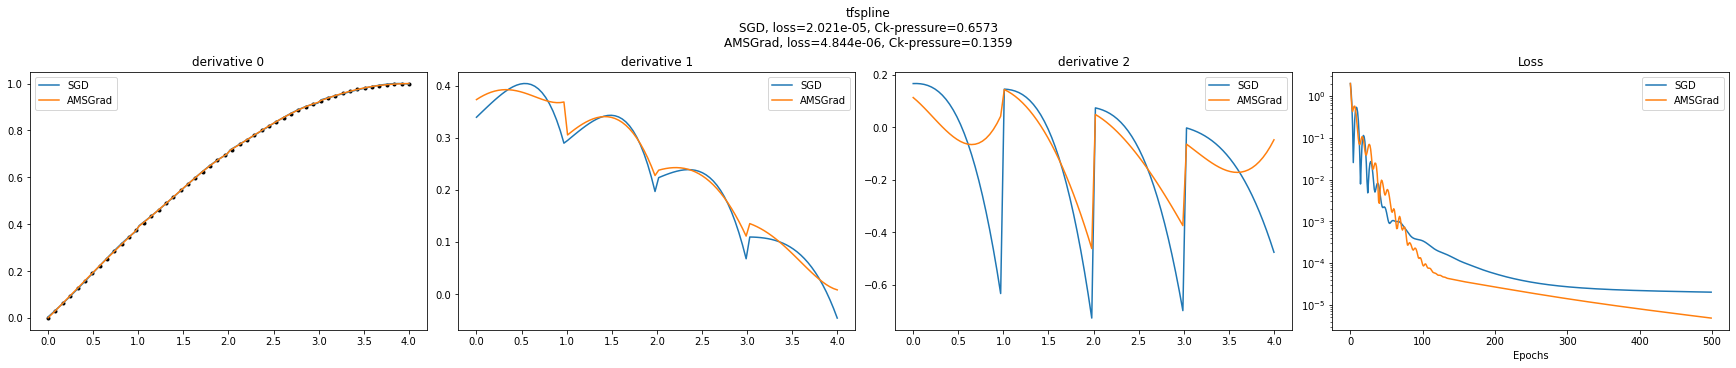

In [36]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=4, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
=8, loss=0.54247epoch=11, loss=0.259543epoch=15, loss=0.0252219epoch=18, loss=0.114203epoch=21, loss=0.0515513epoch=24, loss=0.00481672epoch=27, loss=0.0242358epoch=30, loss=0.02025epoch=34, loss=0.00503947epoch=37, loss=0.00799998epoch=40, loss=0.00617473epoch=43, loss=0.00262056epoch=46, loss=0.00219181epoch=49, loss=0.00192377epoch=53, loss=0.000949332epoch=56, loss=0.000957687epoch=59, loss=0.00104899epoch=62, loss=0.00100334epoch=65, loss=0.000991313epoch=68, loss=0.000968654epoch=71, loss=0.000869664epoch=74, loss=0.000742869epoch=78, loss=0.000593379epoch=81, loss=0.000500978epoch=84, loss=0.000435031epoch=87, loss=0.00039789epoch=90, loss=0.000379594epoch=93, loss=0.000369398epoch=96, loss=0.000360396epoch=99, loss=0.000347621epoch=103, loss=0.000321277epoch=106, loss=0.000296589epoch=110, loss=0.000262574epoch=113, loss=0.000239437epoch=116, loss=0.000220104epoch=119, loss=0.000204885epoch=122, loss=0.00019309epoch=125, loss=0.000183588epoch=128, loss=0.

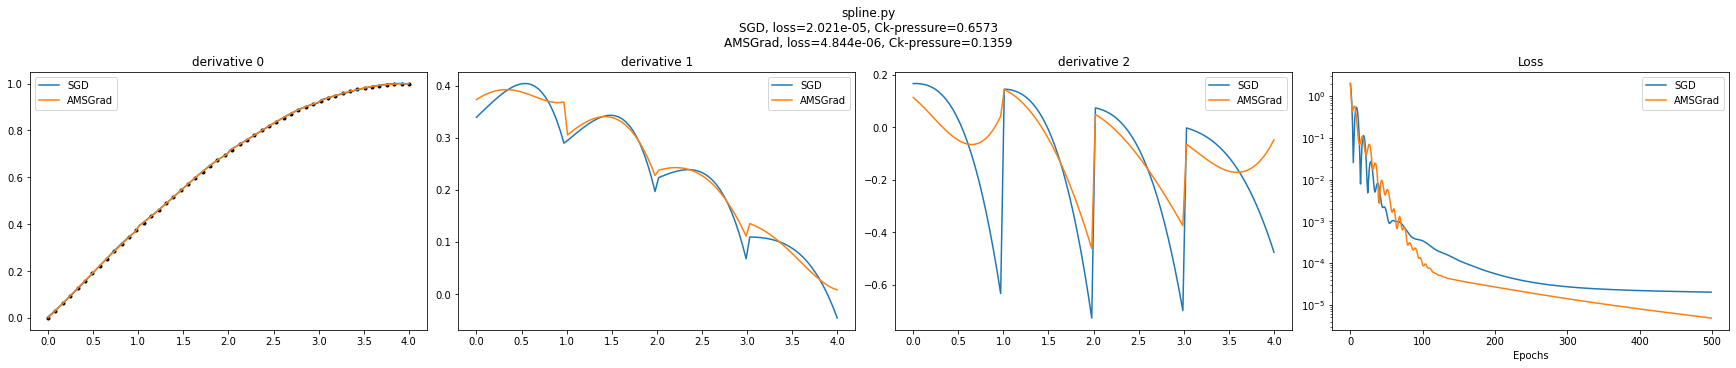

In [37]:
fig_spline_py_4_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=4, ep=epochs)

## 8 Polynomials

In [38]:
x = 8 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 20.126424074172974 seconds
TensorFlow: Number of recognized GPUs:  0
6Fitting took 20.57140040397644 seconds


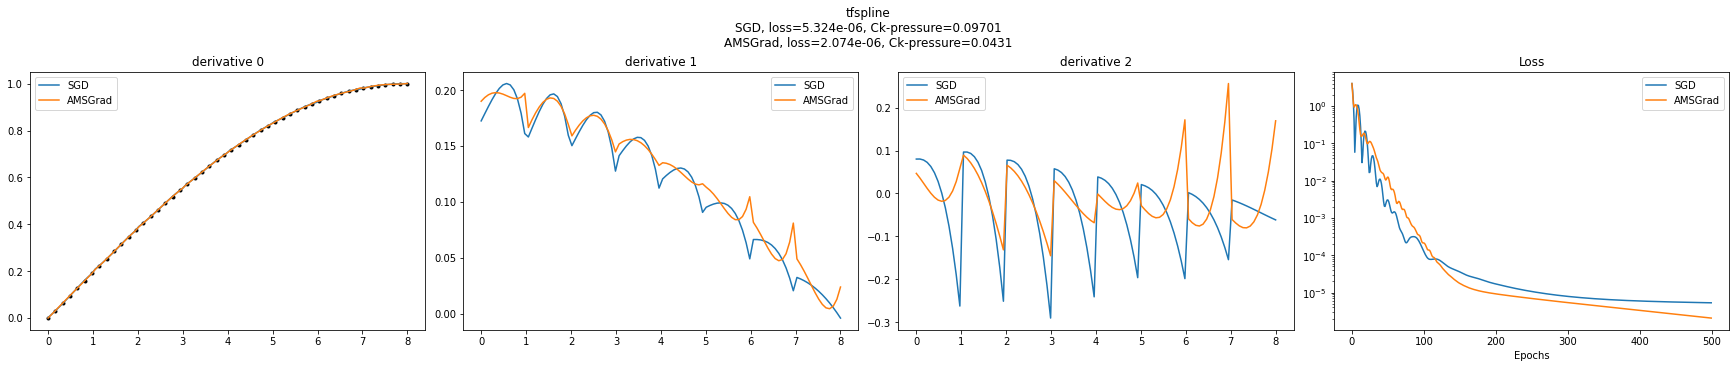

In [39]:
fig_tfspline_8_polynomials = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=8, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
och=74, loss=0.00022995epoch=77, loss=0.000228536epoch=80, loss=0.000283114epoch=83, loss=0.000311414epoch=86, loss=0.000315724epoch=89, loss=0.000300436epoch=92, loss=0.00025827epoch=95, loss=0.000202573epoch=97, loss=0.00016759epoch=100, loss=0.000124836epoch=103, loss=9.58904e-05epoch=106, loss=8.12151e-05epoch=109, loss=7.74017e-05epoch=112, loss=7.85001e-05epoch=115, loss=7.97807e-05epoch=118, loss=7.87936e-05epoch=121, loss=7.48649e-05epoch=124, loss=6.87331e-05epoch=127, loss=6.18618e-05epoch=130, loss=5.55449e-05epoch=133, loss=5.0466e-05epoch=136, loss=4.67079e-05epoch=139, loss=4.39349e-05epoch=142, loss=4.16541e-05epoch=144, loss=4.02008e-05epoch=147, loss=3.79586e-05epoch=150, loss=3.56255e-05epoch=153, loss=3.3319e-05epoch=156, loss=3.12076e-05epoch=159, loss=2.94174e-05epoch=161, loss=2.84229e-05epoch=164, loss=2.71961e-05epoch=167, loss=2.61952e-05epoch=170, loss=2.53003e-05epoch=173, loss=2.44125e-05epoch=176, loss=2.34802e-05epoch=179, loss=2.250

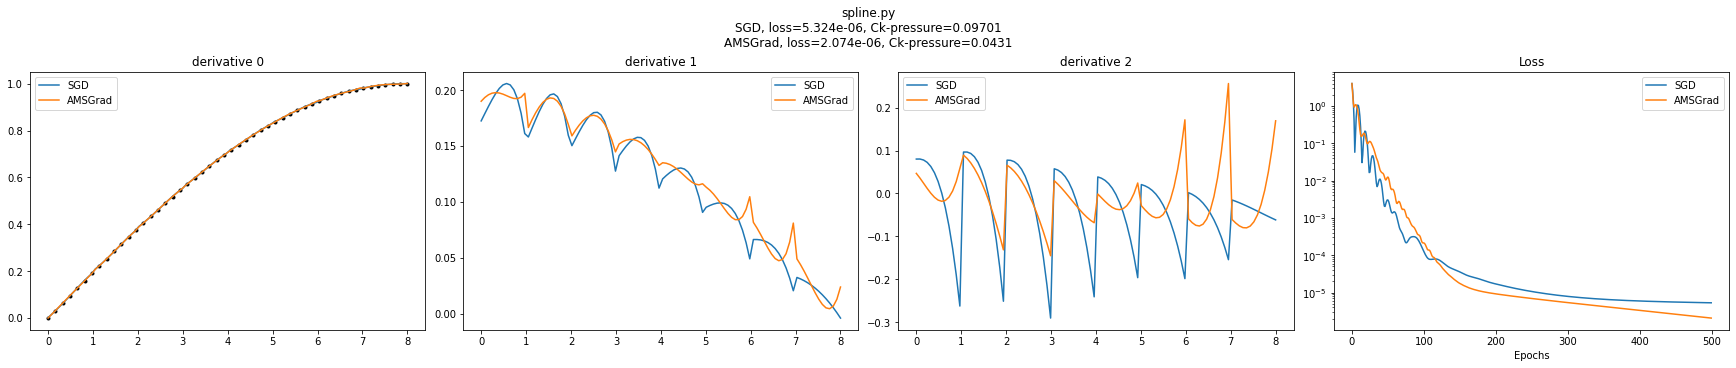

In [40]:
fig_spline_py_8_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=8, ep=epochs)

## 12 Polynomials

In [41]:
x = 12 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
poch=280, loss=5.05646e-06epoch=300, loss=4.67778e-06epoch=320, loss=4.33849e-06epoch=340, loss=4.03136e-06epoch=360, loss=3.75181e-06epoch=380, loss=3.49628e-06epoch=400, loss=3.26185e-06epoch=420, loss=3.04611e-06epoch=440, loss=2.84704e-06epoch=460, loss=2.66299e-06epoch=480, loss=2.49253e-06Fitting took 30.536497354507446 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 30.062466382980347 seconds


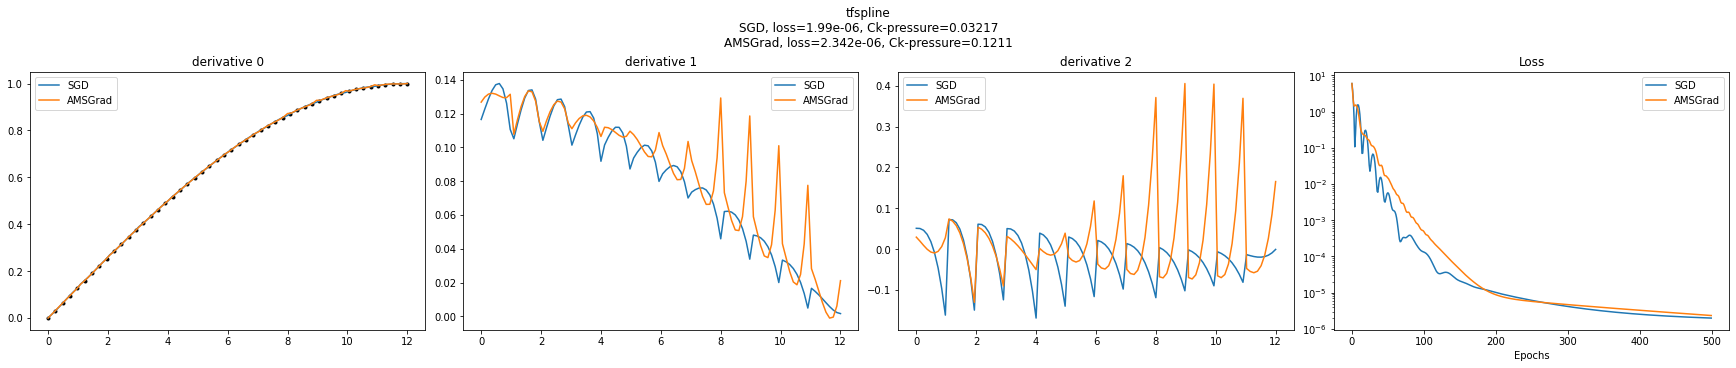

In [42]:
fig_tfspline_12_polynomials = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=12, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True)

Use supplied optimizer
poch=410, loss=2.44821e-06epoch=413, loss=2.42531e-06epoch=416, loss=2.40312e-06epoch=419, loss=2.38162e-06epoch=422, loss=2.36078e-06epoch=425, loss=2.34059e-06epoch=428, loss=2.321e-06epoch=431, loss=2.30201e-06epoch=434, loss=2.28358e-06epoch=437, loss=2.2657e-06epoch=440, loss=2.24835e-06epoch=443, loss=2.23151e-06epoch=446, loss=2.21515e-06epoch=448, loss=2.20451e-06epoch=451, loss=2.18893e-06epoch=454, loss=2.1738e-06epoch=457, loss=2.15909e-06epoch=460, loss=2.14479e-06epoch=463, loss=2.13089e-06epoch=466, loss=2.11737e-06epoch=469, loss=2.10421e-06epoch=472, loss=2.09141e-06epoch=475, loss=2.07896e-06epoch=478, loss=2.06683e-06epoch=481, loss=2.05502e-06epoch=484, loss=2.04351e-06epoch=487, loss=2.03231e-06epoch=490, loss=2.02138e-06epoch=493, loss=2.01073e-06epoch=496, loss=2.00035e-06epoch=499, loss=1.99022e-06
Use supplied optimizer
epoch=499, loss=2.3421e-066


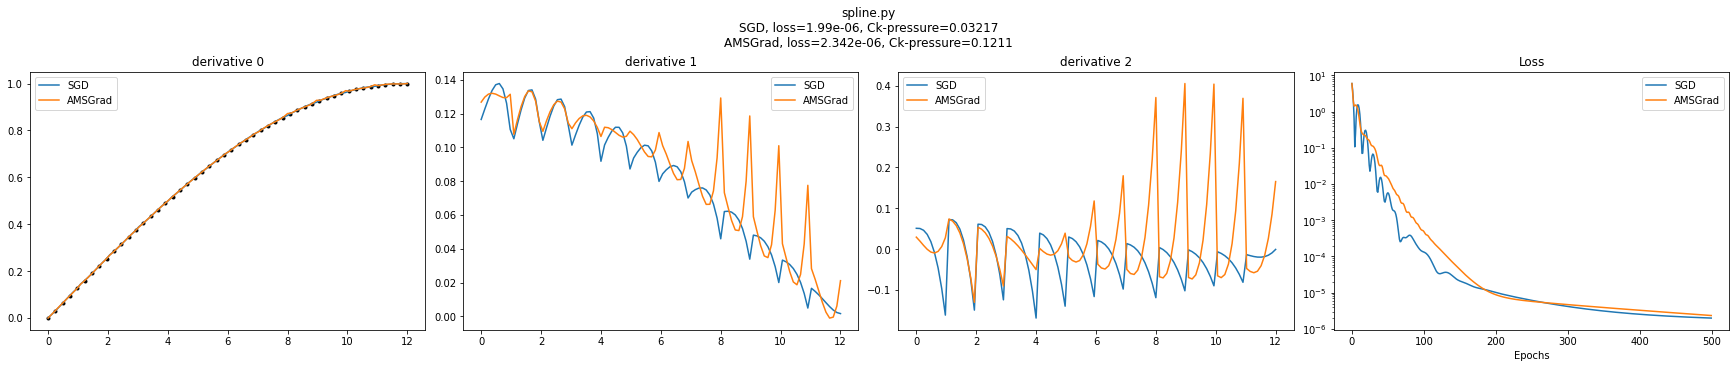

In [43]:
fig_spline_py_12_polynomials = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=12, ep=epochs)

### Discussion
Results are the same for both implementations.

## Optimizing Ck-pressure
We need to configure shifting mode "mean" in order for the x-interval range to converge with $\lambda \neq 1$.
See "scaling_shifting_lambdasweep.ipynb" for details.

In [8]:
x = 2 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 16.37422227859497 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 15.366400718688965 seconds


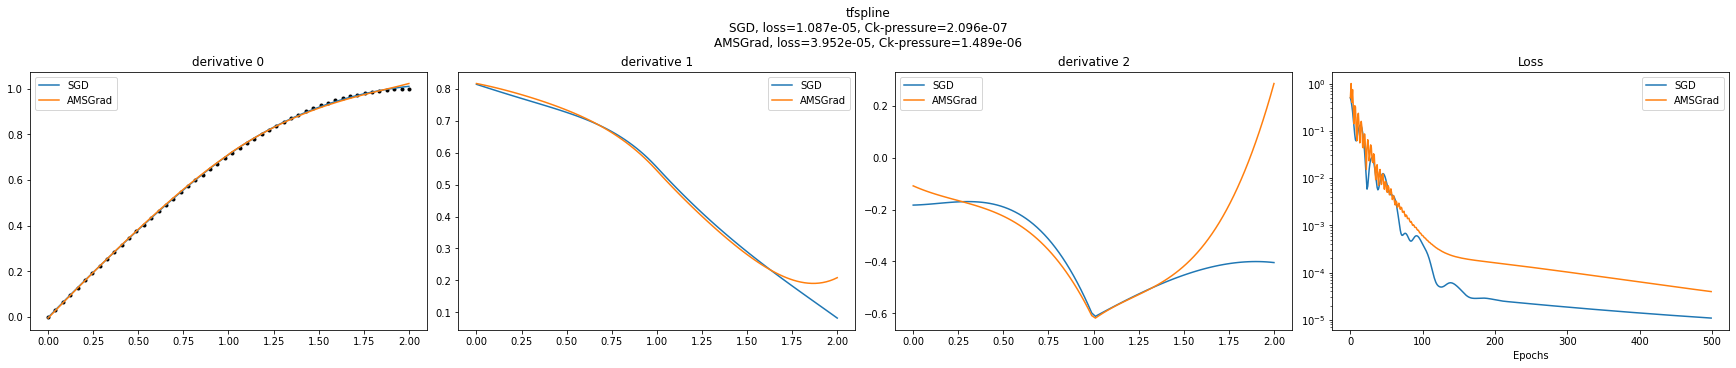

In [9]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, shift_polynomial_centers='mean', overlap_segments=0, split_uniform=True, lambd=0.5, initialize_l2_fit=False, ck=2)

Use supplied optimizer
poch=245, loss=0.206979epoch=248, loss=0.214045epoch=251, loss=0.221438epoch=255, loss=0.231774epoch=258, loss=0.239865epoch=261, loss=0.248233epoch=264, loss=0.256864epoch=268, loss=0.268754epoch=271, loss=0.277938epoch=274, loss=0.287331epoch=278, loss=0.300147epoch=281, loss=0.309951epoch=285, loss=0.32324epoch=288, loss=0.333343epoch=291, loss=0.343542epoch=295, loss=0.357257epoch=298, loss=0.367611epoch=301, loss=0.378007epoch=305, loss=0.391912epoch=308, loss=0.402362epoch=311, loss=0.412821epoch=314, loss=0.42328epoch=318, loss=0.437218epoch=321, loss=0.447657epoch=324, loss=0.458079epoch=327, loss=0.468478epoch=330, loss=0.47885epoch=333, loss=0.489188epoch=336, loss=0.499489epoch=339, loss=0.509746epoch=342, loss=0.519954epoch=346, loss=0.533482epoch=349, loss=0.543558epoch=352, loss=0.553571epoch=355, loss=0.563514epoch=358, loss=0.573386epoch=361, loss=0.583182epoch=364, loss=0.5929epoch=367, loss=0.602536epoch=370, loss=0.61209epoch=373, loss=0.621557

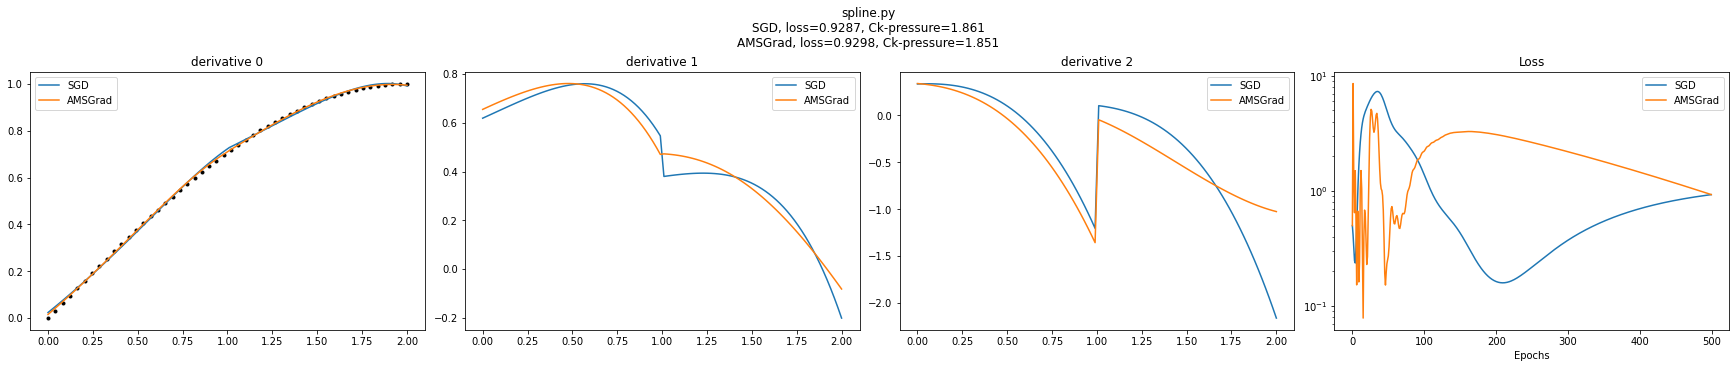

In [10]:
fig = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=2, ep=epochs, lambd=0.5, initialize_l2_fit=False)

In [11]:
x = 8 * data_x_norm

TensorFlow: Number of recognized GPUs:  0
Fitting took 82.68083882331848 secondsloss=3.33104e-05epoch=170, loss=2.4663e-05epoch=190, loss=1.82075e-05epoch=210, loss=1.35811e-05epoch=230, loss=1.02273e-05epoch=250, loss=7.81834e-06epoch=270, loss=6.10063e-06epoch=290, loss=4.88219e-06epoch=310, loss=4.01923e-06epoch=330, loss=3.40607e-06epoch=350, loss=2.96643e-06epoch=370, loss=2.64625e-06epoch=390, loss=2.40787e-06epoch=410, loss=2.22545e-06epoch=430, loss=2.08146e-06epoch=450, loss=1.96418e-06epoch=470, loss=1.86577e-06epoch=490, loss=1.78102e-06
TensorFlow: Number of recognized GPUs:  0
Fitting took 81.24110317230225 seconds


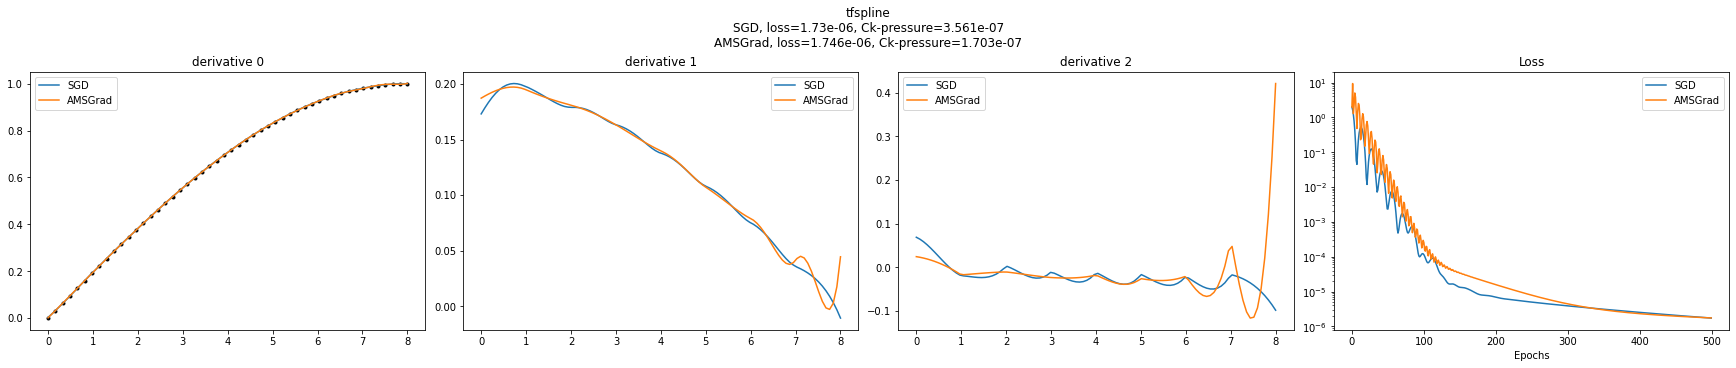

In [12]:
fig = plot_tfspline_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=8, ep=epochs, shift_polynomial_centers='boundary', overlap_segments=0, split_uniform=True, lambd=0.5, initialize_l2_fit=False)

Use supplied optimizer
ch=45, loss=0.188684epoch=47, loss=0.159301epoch=50, loss=0.13119epoch=52, loss=0.118859epoch=55, loss=0.100691epoch=58, loss=0.0807551epoch=60, loss=0.0692902epoch=62, loss=0.0611259epoch=65, loss=0.054577epoch=67, loss=0.0521065epoch=69, loss=0.0498746epoch=72, loss=0.0470366epoch=74, loss=0.0465828epoch=76, loss=0.0480785epoch=78, loss=0.0515512epoch=80, loss=0.0564053epoch=83, loss=0.0643142epoch=85, loss=0.0689021epoch=88, loss=0.0738898epoch=91, loss=0.0766686epoch=93, loss=0.0775383epoch=95, loss=0.077777epoch=98, loss=0.0771212epoch=100, loss=0.0760623epoch=103, loss=0.0735618epoch=105, loss=0.0712808epoch=108, loss=0.0669691epoch=110, loss=0.063586epoch=113, loss=0.0580388epoch=115, loss=0.0542529epoch=118, loss=0.048832epoch=120, loss=0.0455677epoch=122, loss=0.0426726epoch=125, loss=0.0390855epoch=127, loss=0.0371938epoch=129, loss=0.0356739epoch=132, loss=0.034008epoch=134, loss=0.0332418epoch=137, loss=0.0324945epoch=139, loss=0.0322024epoch=141, los

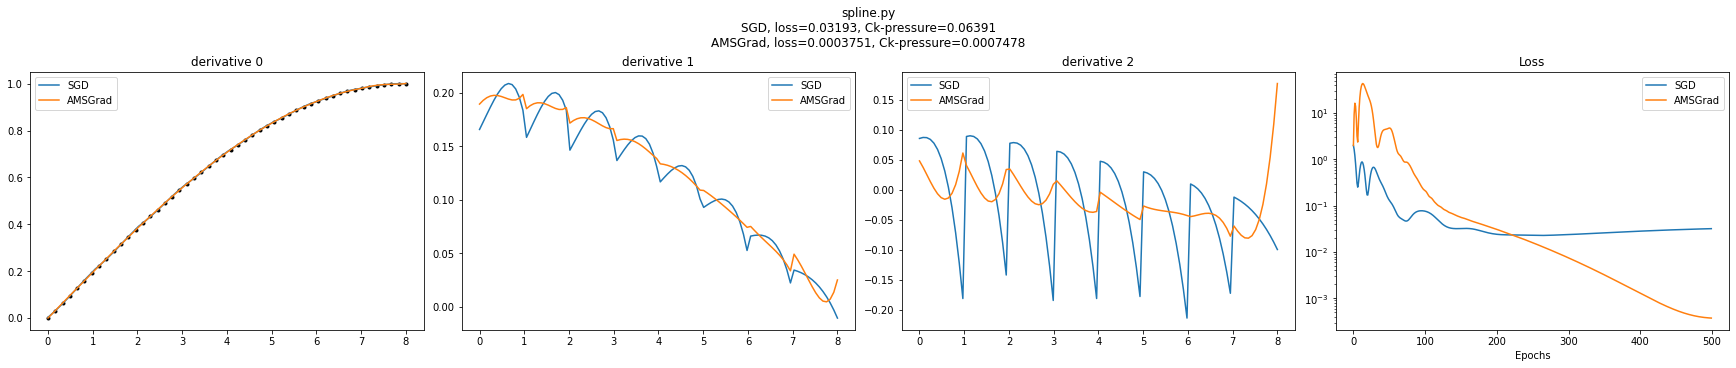

In [13]:
fig = plot_spline_py_result(x, data_y_norm, np.linspace(0, x[-1], 100, dtype="double"), p_num=8, ep=epochs, lambd=0.5, initialize_l2_fit=False)

### Discussion

Although we have confirmed that spline.py's ck-loss function numerically delivers the same result as the tfspline version if we have the same input,
with the spline.py version the TensorFlow GradientTape somehow only considers derivative 0 for Ck-optimization.
Discontinuities in derivatives 1 and 2 remain.
With $\lambda=0.5$ the tfspline implementation delivers an almost $C^2$-continuous result, while the spline.py result is $C^0$-continuous.
